<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/analysis_plot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np

In [19]:
#prepare the dataset for total disabled people by regions
total=pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv')
eng_disability_data = total[total['Lower tier local authorities Code'].str.startswith('E')]
filtered_disability_data = eng_disability_data[eng_disability_data['Disability (5 categories) Code'].isin([1, 2])]
disabled = filtered_disability_data.groupby('Lower tier local authorities')['Observation'].sum().reset_index()

disabled

,Lower tier local authorities,Observation
0,Adur,12577
1,Allerdale,19205
2,Amber Valley,25066
3,Arun,32481
4,Ashfield,27809
...,...,...
304,Worthing,21303
305,Wychavon,22955
306,Wyre,24771
307,Wyre Forest,20459


In [20]:
#prepare the blue badged population by regions
blue_badge = pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Blue_badges_held.csv', delimiter=';')
blue_badges_narrowed =  blue_badge[['Local Authority', 'Total valid Blue Badges held by organisations and individuals']]
filtered_blue_badges = blue_badges_narrowed[~blue_badges_narrowed['Local Authority'].str.contains('All')]

filtered_blue_badges


,Local Authority,Total valid Blue Badges held by organisations and individuals
2,County Durham,27.884
3,Darlington,5.945
4,Hartlepool,5.530
5,Middlesbrough,6.546
6,Northumberland,16.242
...,...,...
163,Wiltshire,23.267
164,Devon,41.387
165,Dorset,25.370
166,Gloucestershire,28.348


In [21]:
#merge the two datasets
merged_data = pd.merge(filtered_blue_badges, disabled, left_on='Local Authority', right_on='Lower tier local authorities', how='inner')


# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric(merged_data['Observation'])
merged_data

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
0,County Durham,27.884,County Durham,119790
1,Darlington,5.945,Darlington,21104
2,Hartlepool,5.530,Hartlepool,21145
3,Middlesbrough,6.546,Middlesbrough,29520
4,Northumberland,16.242,Northumberland,67190
...,...,...,...,...
102,South Gloucestershire,14.238,South Gloucestershire,47429
103,Swindon,12.615,Swindon,37075
104,Torbay,8.325,Torbay,33224
105,Wiltshire,23.267,Wiltshire,86495


# **1. Summary Statistics**

In [46]:
reg_df=merged_data.drop(['Lower tier local authorities'],axis=1)
reg_df['Local Authority']=reg_df['Local Authority'].astype('category')
reg_df.rename(columns={'Observation': 'Disable_population'}, inplace=True)
reg_df.rename(columns={'Total valid Blue Badges held by organisations and individuals': 'Blue_Badges_population'}, inplace=True)
reg_df

,Local Authority,Blue_Badges_population,Disable_population
0,County Durham,27.884,119790
1,Darlington,5.945,21104
2,Hartlepool,5.530,21145
3,Middlesbrough,6.546,29520
4,Northumberland,16.242,67190
...,...,...,...
102,South Gloucestershire,14.238,47429
103,Swindon,12.615,37075
104,Torbay,8.325,33224
105,Wiltshire,23.267,86495


In [47]:
summary=reg_df.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,107.0,12.95,14.56,2.44,7.26,9.91,14.11,146.0
Disable_population,107.0,46277.83,26126.44,294.00,31936.00,39466.00,54729.50,198064.0


# **2. Visualization**
no need for that

# **3. Assumptions**

Text(87.72222222222221, 0.5, 'Blue Badges population')

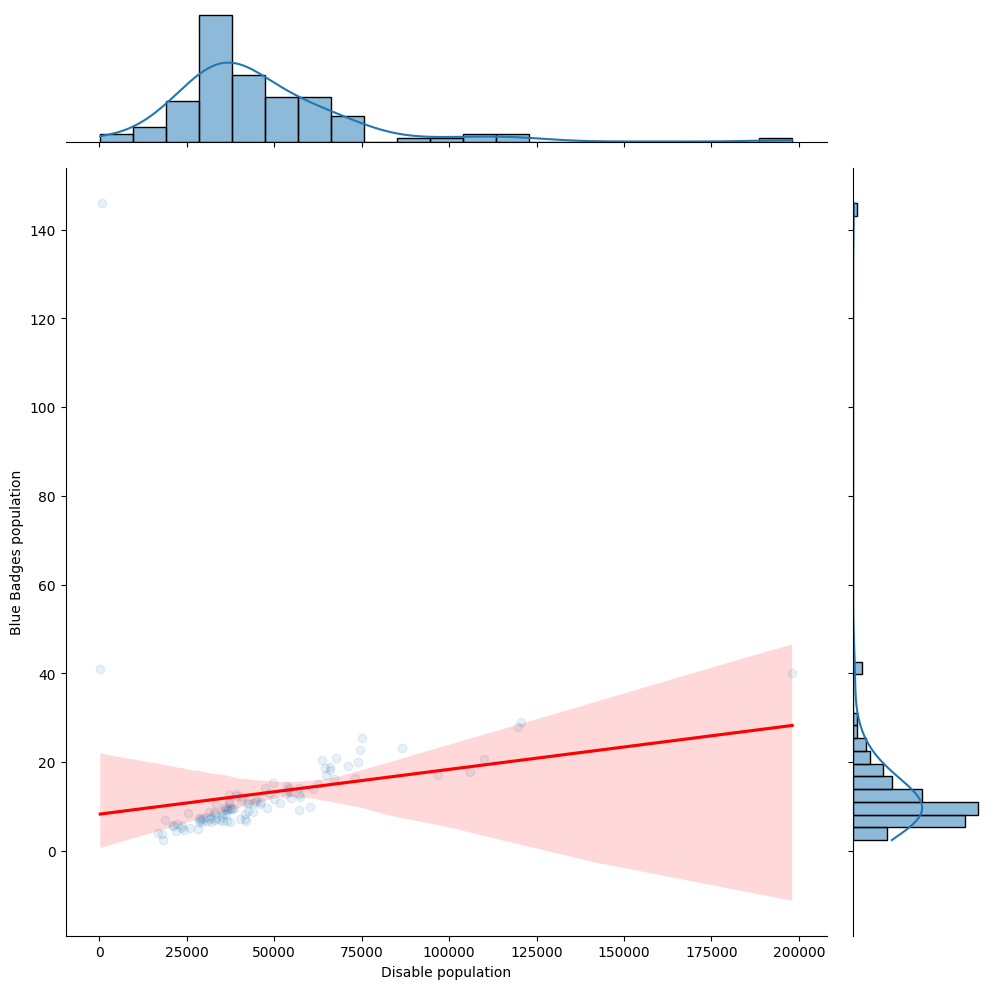

In [48]:
#Homoscedasticity
sns.jointplot(data=reg_df, # plot a scatterplot with a regression line and two histograms
                x='Disable_population', # set the x axis to be the years of schooling
                y='Blue_Badges_population', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Disable population') # add a label to the x axis
plt.ylabel('Blue Badges population') # add a label to the y axis

# **4. Regression**

In [50]:
from statsmodels.formula.api import ols #the function
from statsmodels.iolib.summary2 import summary_col #to produce a very nice table

model= ols('Blue_Badges_population ~  Disable_population', data=reg_df).fit() # fit the model
print(model.summary()) # print the summary

                              OLS Regression Results                              
Dep. Variable:     Blue_Badges_population   R-squared:                       0.033
Model:                                OLS   Adj. R-squared:                  0.024
Method:                     Least Squares   F-statistic:                     3.559
Date:                    Wed, 10 Jan 2024   Prob (F-statistic):             0.0620
Time:                            17:45:43   Log-Likelihood:                -436.14
No. Observations:                     107   AIC:                             876.3
Df Residuals:                         105   BIC:                             881.6
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

1.The R-squared of 0.033 sugested that **only 3.3%% of the variation in blue badges population can be explained by the total disabled population**, imples that there could be more varables(loneliness, spread of transportation and accessibility of transportation and etc.) that affecting the blue badges population.

2.The coefficient of 0.0001 means **10000 unit increase in total diabled population will lead to 1 unit increase in blue badges population**


3.The p-value of 0.004 is less that 0.05, suggests that the coefficient is statistically significant at the 5% level and **we can reject the null hypothesis.**